In [1]:
cd /data/projects/windturbine-identification/MachineLearningCourse

/data/projects/windturbine-identification/MachineLearningCourse


In [19]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 18 13:04:17 2019

@author: jschmidt
"""
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

import pickle  # pip install dill --user
import matplotlib.pyplot as plt
from keras.applications import VGG16
import tensorflow as tf

import imp
import scripts.windturbines.functions_pattern_recognition as fpr
imp.reload(fpr)

gpu_fraction = 0.8
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


# Training Phase

In [20]:
COUNTRY = "MIX"

t_base_dir = fpr.get_param(COUNTRY, "PATH_ML_IMAGES_TURBINES_TRAIN") + "../"

v_base_dir = fpr.get_param(COUNTRY,
                           "PATH_ML_IMAGES_TURBINES_VALIDATION") + "../"

test_base_dir = fpr.get_param(COUNTRY, "PATH_ML_IMAGES_TURBINES_TEST") + "../"

# Part II: Pretrained model


conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        t_base_dir,
        # All images will be resized to 150x150
        # target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        v_base_dir,
        # target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

mcp_save = ModelCheckpoint('models/model-unfreezed-2-layer-2-layer-classification-6497-turbines-{epoch:04d}-{val_loss:.4f}.h5',
                           save_best_only=True, monitor='val_loss', mode='min')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[mcp_save],
      verbose=2)



Found 9075 images belonging to 2 classes.
Found 1944 images belonging to 2 classes.
Epoch 1/30
 - 37s - loss: 0.3771 - acc: 0.8185 - val_loss: 0.2442 - val_acc: 0.9250
Epoch 2/30
 - 36s - loss: 0.2112 - acc: 0.9205 - val_loss: 0.1883 - val_acc: 0.9431
Epoch 3/30
 - 36s - loss: 0.1655 - acc: 0.9390 - val_loss: 0.0861 - val_acc: 0.9690
Epoch 4/30
 - 35s - loss: 0.1754 - acc: 0.9405 - val_loss: 0.0836 - val_acc: 0.9776
Epoch 5/30
 - 37s - loss: 0.1258 - acc: 0.9517 - val_loss: 0.2176 - val_acc: 0.9470
Epoch 6/30
 - 36s - loss: 0.1295 - acc: 0.9510 - val_loss: 0.0688 - val_acc: 0.9746
Epoch 7/30
 - 36s - loss: 0.1434 - acc: 0.9540 - val_loss: 0.0548 - val_acc: 0.9800
Epoch 8/30
 - 36s - loss: 0.1250 - acc: 0.9540 - val_loss: 0.0760 - val_acc: 0.9848
Epoch 9/30
 - 36s - loss: 0.1292 - acc: 0.9550 - val_loss: 0.0716 - val_acc: 0.9800
Epoch 10/30
 - 35s - loss: 0.1296 - acc: 0.9553 - val_loss: 0.0675 - val_acc: 0.9797
Epoch 11/30
 - 36s - loss: 0.1143 - acc: 0.9555 - val_loss: 0.0841 - val_ac

# Validation vs. Training

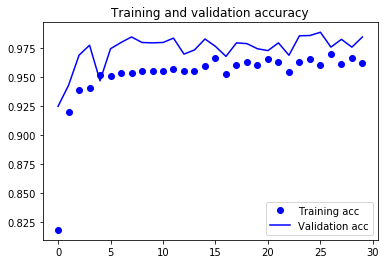

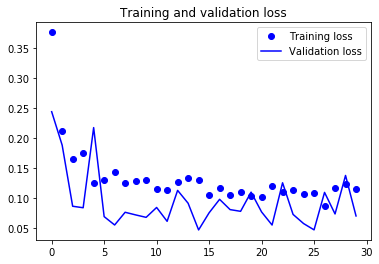

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()




# Model selection

In [22]:
min_val_loss = min(val_loss)

i = val_loss.index(min_val_loss) + 1

best_model = "models/model-unfreezed-2-layer-2-layer-classification-6497-turbines-" + "{0:0=4d}".format(i) + "-" + "{0:.4f}".format(min_val_loss) + ".h5"

#best_model = "models/model-unfreezed-2-layer-2-layer-classification-6497-turbines-0005-0.0339.h5"

best_model

'models/model-unfreezed-2-layer-2-layer-classification-6497-turbines-0015-0.0465.h5'

# Test

In [23]:
test_base_dir = fpr.get_param(COUNTRY, "PATH_ML_IMAGES_TURBINES_TEST")+"../"

test_model = models.load_model(best_model)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_base_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary')

test_loss, test_acc = test_model.evaluate_generator(test_generator, steps=32)
print('test acc:', test_acc)
print('test loss:', test_loss)


Found 1946 images belonging to 2 classes.
test acc: 0.9765625
test loss: 0.06705017705098726
